# Diabetes prediction: gradient boosting

## Notebook set-up

In [1]:
# Python standard library imports
import os
import pickle
import time
from pathlib import Path

# PyPI imports - data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# PyPI imports - statistical and machine learning libraries
from scipy.stats import randint, uniform, loguniform
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

# Internal imports - project-specific modules
import configuration as config
import functions as funcs

# Wait for the random forest notebook to finish execution
while True:
    if os.path.exists(config.RANDOM_FOREST_MODEL):
        break

    else:
        time.sleep(5)

## 1. Data loading

### 1.1. Load data from disk

Load the pre-processed data from the decision tree notebook:

In [2]:
# Load the preprocessed dataset that was saved from the decision tree notebook
with open(config.DATA_FILE, 'rb') as input_file:
    dataset = pickle.load(input_file)

# Extract training and testing dataframes from the loaded dictionary
training_df = dataset['training']
testing_df = dataset['testing']

### 1.2. Inspect

In [3]:
training_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
254,12,92.0,62.0,7.000000,258.000000,27.6,0.926,44,1
323,13,152.0,90.0,33.000000,29.000000,26.8,0.731,43,1
447,0,95.0,80.0,45.000000,92.000000,36.5,0.330,26,0
499,6,154.0,74.0,32.000000,193.000000,29.3,0.839,39,0
226,0,101.0,76.0,40.539577,113.252114,35.7,0.198,26,0


## 2. Model training

### 2.1. Previous scores

In [4]:
# Load cross validation scores from previous models
with open(config.CROSS_VAL_SCORES_FILE, 'rb') as input_file:
    cross_val_scores = pickle.load(input_file)

### 2.2. Gradient boosting model

In [5]:
# Create a gradient boosting classifier with default hyperparameters
naive_model = HistGradientBoostingClassifier(
    class_weight=config.CLASS_WEIGHT,
    random_state=config.RANDOM_SEED
)

# Train the naive gradient boosting model
naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Calculate and display training accuracy
accuracy = accuracy_score(naive_model.predict(training_df.drop('Outcome', axis=1)), training_df['Outcome'])*100
print(f'Training accuracy of gradient boosting model: {accuracy:.1f}%')

Training accuracy of gradient boosting model: 99.7%


In [6]:
# Perform cross-validation on the naive gradient boosting model
scores = cross_val_score(
    naive_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with previous models and future optimized model
cross_val_scores['Model'].extend(['Gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results with mean and standard deviation
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 74.7 +/- 6.0%


## 3. Hyperparameter optimization

### 3.1. Hyperparameter search

In [7]:
%%time

# Define hyperparameter search space for gradient boosting optimization
hyperparameters = {
    #'loss': ['log_loss', 'exponential'],
    'learning_rate': loguniform(10**-5, 1.0),
    'max_iter': randint(2, 200),
    'max_leaf_nodes':randint(2, 1000),
    'max_depth':randint(1, 20),
    'min_samples_leaf': randint(1, 20),
    'l2_regularization': loguniform(10**-5, 1.0),
    'max_features':uniform(loc=0.1, scale=0.9),
    'max_bins': randint(10, 255),
    'interaction_cst': ['pairwise', 'no_interactions'],
    #'subsample': uniform(loc=0.1, scale=0.9),
}

# Perform randomized search over hyperparameters
search = RandomizedSearchCV(
    HistGradientBoostingClassifier(class_weight=config.CLASS_WEIGHT, random_state=config.RANDOM_SEED),
    hyperparameters,
    return_train_score=True,                 # Return training scores for analysis
    cv=config.CROSS_VAL_FOLDS,               # Number of cross-validation folds
    n_jobs=-1,                               # Use all available CPU cores
    n_iter=config.RANDOM_SEARCH_ITERATIONS,  # Number of parameter combinations to try
    random_state=config.RANDOM_SEED          # Ensure reproducible results
)

# Fit the search and extract best model and parameters
search_results = search.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])
best_model = search_results.best_estimator_
winning_hyperparameters = search_results.best_params_

# Display the best hyperparameters found
print('Best hyperparameters:\n')

for key, value in search_results.best_params_.items():
    print(f' {key}: {value}')

print()

print(f'Run time ({os.cpu_count()} CPUs):\n')

Best hyperparameters:

 interaction_cst: pairwise
 l2_regularization: 2.6982144223449972e-05
 learning_rate: 0.0005107749753732836
 max_bins: 18
 max_depth: 7
 max_features: 0.11070506087120957
 max_iter: 174
 max_leaf_nodes: 307
 min_samples_leaf: 1

Run time (20 CPUs):

CPU times: user 3min 30s, sys: 6.74 s, total: 3min 37s
Wall time: 19min 59s


### 3.2. Hyperparameter optimization results

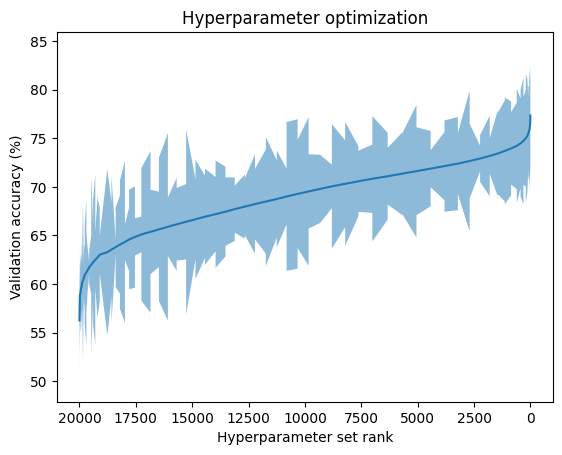

In [8]:
funcs.plot_cross_validation(search_results)

### 3.3. Cross-validation of optimized model

In [9]:
# Perform cross-validation on the optimized gradient boosting model
scores = cross_val_score(
    best_model,
    training_df.drop('Outcome', axis=1),
    training_df['Outcome'],
    cv=config.CROSS_VAL_FOLDS,  # Number of folds for cross-validation
    n_jobs=-1                   # Use all available CPU cores for parallel processing
)

# Store results for comparison with all other models
cross_val_scores['Model'].extend(['Optimized gradient boosting']*len(scores))
cross_val_scores['Score'].extend(scores*100)

# Display cross-validation results for the optimized gradient boosting model
print(f'Cross-validation accuracy: {np.mean(scores)*100:.1f} +/- {np.std(scores)*100:.1f}%')

Cross-validation accuracy: 77.3 +/- 6.2%


## 4. Evaluation

### 4.1. Cross-validation performance

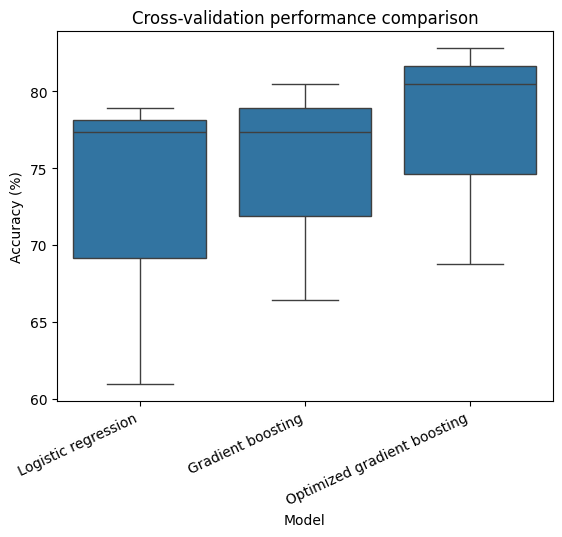

In [10]:
# Create boxplot to compare cross-validation performance
models = ['Logistic regression', 'Gradient boosting', 'Optimized gradient boosting']
plot_scores = pd.DataFrame.from_dict(cross_val_scores)
plot_scores = plot_scores[plot_scores['Model'].isin(models)]

sns.boxplot(plot_scores, x='Model', y='Score')
plt.title('Cross-validation performance comparison')
plt.ylabel('Accuracy (%)')
plt.xticks(rotation=25, ha='right')  # Rotate x-axis labels for better readability
plt.show()

### 4.2. Test set performance

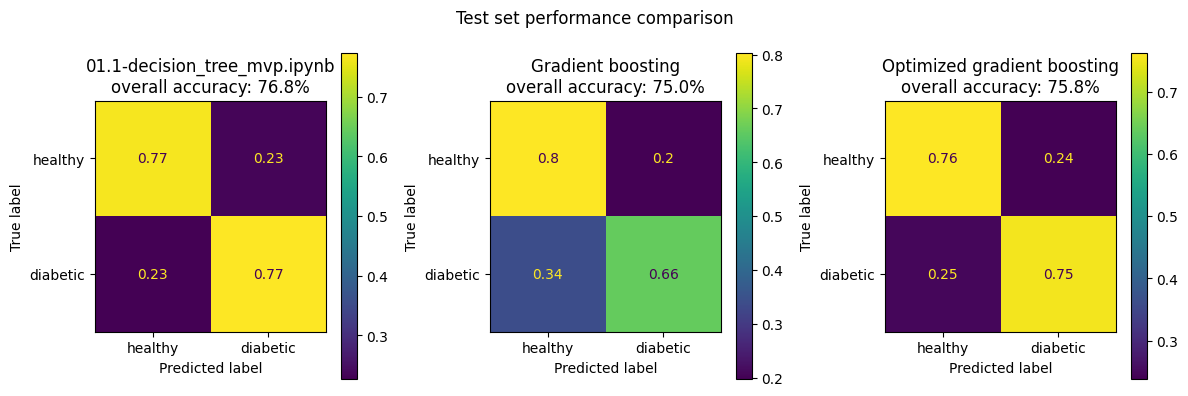

In [11]:
# Retrain both naive and optimized gradient boosting models on the full training set
naive_model = HistGradientBoostingClassifier(
    class_weight=config.CLASS_WEIGHT,
    random_state=config.RANDOM_SEED
)
result = naive_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

best_model = HistGradientBoostingClassifier(
    **winning_hyperparameters,
    class_weight=config.CLASS_WEIGHT,
    random_state=config.RANDOM_SEED
)
result = best_model.fit(training_df.drop('Outcome', axis=1), training_df['Outcome'])

# Load the logistic regression model for comparison
with open(config.LOGISTIC_REGRESSION_MODEL, 'rb') as input_file:
    linear_model = pickle.load(input_file)

# Generate confusion matrices for both gradient boosting models on the test set
funcs.plot_confusion_matrices(
    models = {
        '01.1-decision_tree_mvp.ipynb': linear_model,
        'Gradient boosting': naive_model,
        'Optimized gradient boosting': best_model
    },
    testing_df=testing_df
)

## 6. Save

### 6.1. Cross-validation scores

In [12]:
with open(config.CROSS_VAL_SCORES_FILE, 'wb') as output_file:
    pickle.dump(cross_val_scores, output_file)

### 6.2. Model

In [13]:
# Save the optimal hyperparameters for future use or reproduction
with open(config.GRADIENT_BOOSTING_HYPERPARAMETERS, 'wb') as output_file:
    pickle.dump(winning_hyperparameters, output_file)

# Save the trained best gradient boosting model for deployment or further analysis
with open(config.GRADIENT_BOOSTING_MODEL, 'wb') as output_file:
    pickle.dump(best_model, output_file)  # Fixed: should be best_model, not model